## Question 2

Rows, cols: (1000, 8)
Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

Sample rows:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75



Group sizes: completed=358, none=642

Math score: t=5.787, p=0.0000
Cohen's d (completed - none) = 0.376

Spearman correlation (parental education ordinal vs writing score): rho=0.220, p=0.0000

Pivot table: mean scores by test prep x gender


math score        reading score        writing score  \
gender                      female   male        female   male        female   
test preparation course                                                        
completed                    67.20  72.34         77.38  70.21         78.79   
none                         61.67  66.69         69.98  62.80         68.98   

                                
gender                    male  
test preparation course         
completed                69.79  
none                     59.65


Crosstab: test preparation course x math_pass (0=fail,1=pass)


math_pass,0,1,All
test preparation course,,,
completed,28,330,358
none,107,535,642
All,135,865,1000



Saved figures: math_by_testprep_boxplot.png, writing_by_parentedu_bar.png

-- Interpretation notes (to copy into report) --
- If p < 0.05 for t-test then there is a statistically significant difference in math scores between completed and none groups.
- Cohen's d indicates magnitude: small ~0.2, medium ~0.5, large ~0.8.
- Spearman rho shows monotonic association between parental education (ordinal) and writing score. p < 0.05 indicates significance.


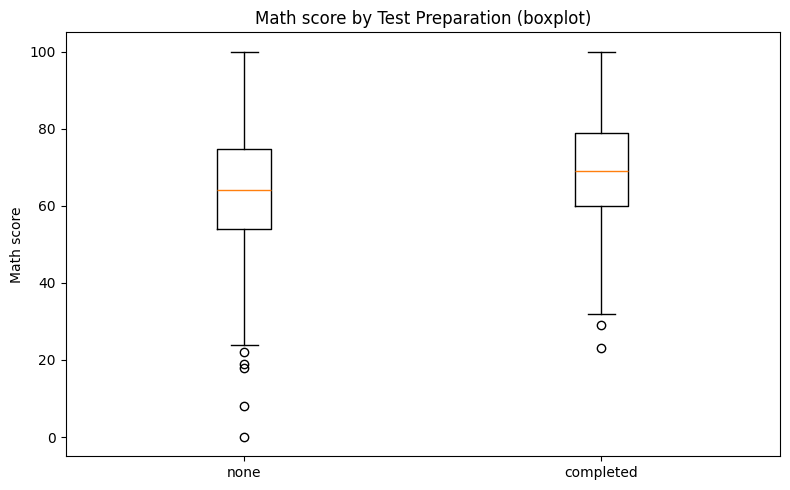

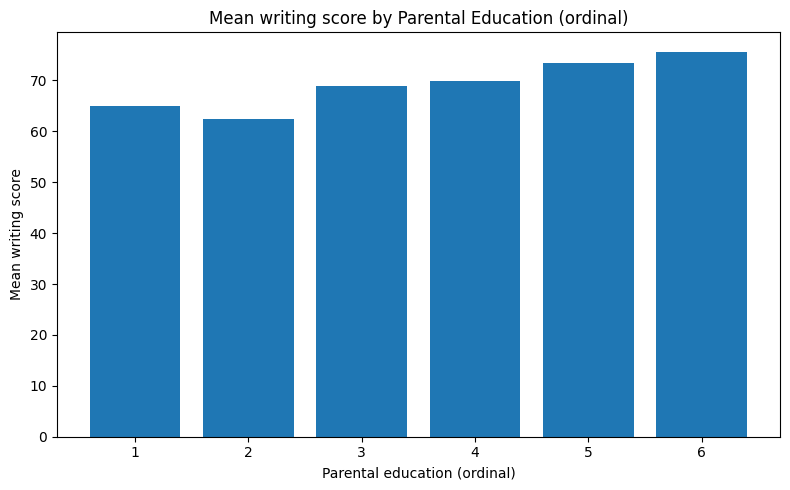

In [1]:
# Question 2 - Project analysis (adapted to StudentsPerformance dataset)
# Change DATA_PATH to your CSV file path if needed.
DATA_PATH = "TM351 -Fall 25-26- KSADATASET.csv"  # or "StudentsPerformance.csv"

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, spearmanr
from math import sqrt

# -------------------------
# Load dataset and checks
# -------------------------
df = pd.read_csv(DATA_PATH)
print("Rows, cols:", df.shape)
print("Columns:", list(df.columns))
print("\nSample rows:")
display(df.head())

# Expected columns for Kaggle students dataset:
# ['gender','race/ethnicity','parental level of education','lunch',
#  'test preparation course','math score','reading score','writing score']

# If column names differ in spacing/case, normalize names:
df.columns = [c.strip() for c in df.columns]

# Quick type conversions (ensure numeric scores)
for col in ['math score','reading score','writing score']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# -------------------------
# Research question (example)
# -------------------------
# RQ1: Is there a statistically significant difference in math score
#      between students who completed the test preparation course vs none?
# Independent: test preparation course (categorical: completed / none)
# Dependent  : math score (numeric)

# RQ2: What is the strength and direction of association between
#      parental level of education (ordinal) and writing score?
# Independent: parental level of education (ordinal)
# Dependent  : writing score (numeric)

# -------------------------
# Prepare groups for RQ1
# -------------------------
if 'test preparation course' in df.columns and 'math score' in df.columns:
    grp_completed = df.loc[df['test preparation course'].str.lower().str.contains('completed', na=False), 'math score'].dropna()
    grp_none = df.loc[df['test preparation course'].str.lower().str.contains('none', na=False), 'math score'].dropna()
    print(f"\nGroup sizes: completed={len(grp_completed)}, none={len(grp_none)}")
else:
    raise ValueError("Required columns for RQ1 not found in dataset")

# -------------------------
# t-test (two-sample, independent)
# -------------------------
t_stat, p_value = ttest_ind(grp_completed, grp_none, equal_var=False)  # Welch t-test
print(f"\nMath score: t={t_stat:.3f}, p={p_value:.4f}")

# Effect size (Cohen's d)
def cohens_d(a, b):
    ma, mb = np.mean(a), np.mean(b)
    sa, sb = np.var(a, ddof=1), np.var(b, ddof=1)
    n1, n2 = len(a), len(b)
    # pooled sd
    pooled_sd = sqrt(((n1-1)*sa + (n2-1)*sb) / (n1 + n2 - 2))
    return (ma - mb) / pooled_sd

d = cohens_d(grp_completed, grp_none)
print(f"Cohen's d (completed - none) = {d:.3f}")

# -------------------------
# RQ2: parental education -> writing score
# -------------------------
if 'parental level of education' in df.columns and 'writing score' in df.columns:
    # Map parental education to an ordinal scale (example ordering)
    # Adjust ordering if dataset uses different categories
    ordinal_map = {
        "some high school": 1,
        "high school": 2,
        "some college": 3,
        "associate's degree": 4,
        "bachelor's degree": 5,
        "master's degree": 6
    }
    col = 'parental level of education'
    df['parent_edu_ord'] = df[col].str.strip().str.lower().map(ordinal_map)
    valid = df[['parent_edu_ord','writing score']].dropna()
    spearman_r, spearman_p = spearmanr(valid['parent_edu_ord'], valid['writing score'])
    print(f"\nSpearman correlation (parental education ordinal vs writing score): rho={spearman_r:.3f}, p={spearman_p:.4f}")
else:
    raise ValueError("Required columns for RQ2 not found in dataset")

# -------------------------
# Crosstabs / Pivot tables
# -------------------------
# Example pivot: mean scores by test preparation and gender
if 'gender' in df.columns:
    pivot = df.pivot_table(index='test preparation course', columns='gender',
                           values=['math score','reading score','writing score'],
                           aggfunc='mean')
    print("\nPivot table: mean scores by test prep x gender")
    display(pivot.round(2))

# Crosstab: test preparation vs pass/fail in math (pass threshold example 50)
df['math_pass'] = (df['math score'] >= 50).astype(int)
ct = pd.crosstab(df['test preparation course'], df['math_pass'], margins=True)
print("\nCrosstab: test preparation course x math_pass (0=fail,1=pass)")
display(ct)

# -------------------------
# Visualizations (matplotlib)
# -------------------------
plt.rcParams['figure.figsize'] = (8,5)

# Boxplot: math score by test preparation
fig1, ax1 = plt.subplots()
groups = [grp_none, grp_completed]
ax1.boxplot(groups, labels=['none','completed'])
ax1.set_title("Math score by Test Preparation (boxplot)")
ax1.set_ylabel("Math score")
fig1.tight_layout()
fig1.savefig("math_by_testprep_boxplot.png", dpi=150)

# Bar chart: mean writing score by parental education ordinal
fig2, ax2 = plt.subplots()
means = valid.groupby('parent_edu_ord')['writing score'].mean()
ax2.bar(means.index.astype(str), means.values)
ax2.set_title("Mean writing score by Parental Education (ordinal)")
ax2.set_xlabel("Parental education (ordinal)")
ax2.set_ylabel("Mean writing score")
fig2.tight_layout()
fig2.savefig("writing_by_parentedu_bar.png", dpi=150)

print("\nSaved figures: math_by_testprep_boxplot.png, writing_by_parentedu_bar.png")

# -------------------------
# Interpretations templates (to include in report)
# -------------------------
print("\n-- Interpretation notes (to copy into report) --")
print("- If p < 0.05 for t-test then there is a statistically significant difference in math scores between completed and none groups.")
print("- Cohen's d indicates magnitude: small ~0.2, medium ~0.5, large ~0.8.")
print("- Spearman rho shows monotonic association between parental education (ordinal) and writing score. p < 0.05 indicates significance.")

# -------------------------
# End of script
# -------------------------
